In [273]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from keras.layers import Dropout
from keras.engine.sequential import Sequential
from keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam, SGD

In [274]:
# data_path = 'tweets_sentiment_score_price_10min_20210205_20220218.csv'
# data = pd.read_csv(data_path).drop(['10min_TimeStart', 'time_period_end', 'time_open', 'time_close'], axis=1)
'''Modify the data_path'''
data_path = '2017-20211231_1day.csv'
data = pd.read_csv(data_path)
data = data.iloc[69:, :]

data = data.drop(['timestamp'], axis=1)

data

,price_open,price_high,price_low,price_close,volume_traded,MACD,SMA,OBV,RSI,MFI,vader_pos,vader_neg,vader_neu,vader_compound,pos_count,neg_count,neu_count
69,7465.06,7490.00,7061.20,7148.00,14799.223470,487.885605,7213.800,21011.38000,61.894679,92.483181,0.105629,0.066181,0.828133,0.158575,52.0,23.0,30.0
70,7150.61,7343.18,6429.44,6588.18,26614.276050,443.227600,7056.892,-5602.89605,56.538439,97.706450,0.103724,0.056571,0.839724,0.109638,46.0,24.0,28.0
71,6588.18,6820.00,6218.00,6355.13,14684.139440,424.636716,6934.382,-20287.03549,55.684709,93.712472,0.098732,0.060876,0.840433,0.108634,46.0,24.0,27.0
72,6355.13,6488.88,5555.55,5870.37,37315.156640,385.966403,6682.400,-57602.19213,52.367057,83.169383,0.100108,0.071343,0.828510,0.079700,42.0,32.0,28.0
73,5870.03,6775.75,5846.00,6525.17,27201.042110,438.201161,6497.370,-30401.15002,56.029065,82.980188,0.103748,0.042573,0.853670,0.169087,50.0,15.0,38.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1578,50885.32,52098.60,50479.44,50718.11,1102.559307,-489.717695,50728.604,-33731.84214,48.316689,63.543348,0.121148,0.061407,0.817457,0.152890,41.0,18.0,22.0
1579,50708.05,50719.59,47300.00,47543.30,2210.721843,-742.978892,50067.264,-35942.56398,45.803309,46.486057,0.112244,0.067385,0.820410,0.179797,44.0,18.0,16.0
1580,47597.70,48157.41,46099.94,46483.36,2089.243028,-827.532510,49195.640,-38031.80701,46.250136,55.796910,0.122795,0.074530,0.802663,0.171357,45.0,24.0,14.0
1581,46474.59,47916.32,45934.37,47150.71,2162.270443,-774.296613,48537.338,-35869.53656,45.455607,90.666055,0.121125,0.067950,0.810937,0.140750,35.0,24.0,21.0


In [275]:
'''Price Data:'''
# data_features = data.drop(['price_close', 'MACD', 'SMA', 'OBV', 'RSI', 'MFI', 'vader_pos', 'vader_neg', 'vader_neu', 'vader_compound', 'pos_count', 'neg_count', 'neu_count'], axis=1)

'''Price Data + Technical Indicator:'''
# data_features = data.drop(['price_close', 'vader_pos', 'vader_neg', 'vader_neu', 'vader_compound', 'pos_count', 'neg_count', 'neu_count'], axis=1)

'''Price Data + Sentiment Indicator:'''
# data_features = data.drop(['price_close', 'MACD', 'SMA', 'OBV', 'RSI', 'MFI', 'pos_count', 'neg_count', 'neu_count'], axis=1)

'''Price Data + Technical Indicator + Sentiment Indicator:'''
# data_features = data.drop(['price_close', 'pos_count', 'neg_count', 'neu_count'], axis=1)

'''Price Data + Technical Indicator in 30 MIN data:'''
# data_features = data.drop(['price_close', 'vader_pos', 'vader_neg', 'vader_neu', 'vader_compound', 'pos_count', 'neg_count', 'neu_count', 'pos_keywords_occur', 'neg_keywords_occur'], axis=1)

'''Price Data + Selected Features'''
data_features = data.drop(['price_close', 'MFI', 'MACD', 'SMA', 'OBV', 'RSI', 'vader_compound', 'vader_pos', 'vader_neg', 'vader_neu', 'pos_count', 'neg_count', 'neu_count', 'volume_traded'], axis=1)


data_labels = data['price_close']

scaler_feature = MinMaxScaler(feature_range=(0, 1))
scaler_label = MinMaxScaler(feature_range=(0, 1))

feature = scaler_feature.fit_transform(data_features.to_numpy())
label = scaler_label.fit_transform(data_labels.to_numpy().reshape(-1, 1))

In [276]:
def split_data(f, l, delay):
    feature, label = [], []

    for i in range(len(f) - delay):
        feature.append(f[i: i + delay])
        label.append(l[i + delay - 1])
        
    return np.array(feature), np.array(label).squeeze()

GRU_window_size = 30

feature, label = split_data(feature, label, GRU_window_size)

train_size = int(0.8 * len(label))

X_train, X_test = feature[:train_size], feature[train_size:]
y_train, y_test = label[:train_size], label[train_size:]

print(X_train.shape, X_test.shape)

(1187, 30, 3) (297, 30, 3)


In [277]:
model = keras.Sequential([
      layers.Bidirectional(layers.LSTM(32)),
      layers.Dense(1)
])

In [278]:
model.compile(loss='mean_absolute_error',
                optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.00005),
                metrics=[keras.metrics.RootMeanSquaredError()]
                )
history = model.fit(X_train, y_train,
                    epochs=250,
                    batch_size=500,
                    shuffle=True
                    )

Epoch 1/250


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


3/3 [==============================] - 3s 10ms/step - loss: 0.1067 - root_mean_squared_error: 0.1664
Epoch 2/250
3/3 [==============================] - 0s 10ms/step - loss: 0.0504 - root_mean_squared_error: 0.0992
Epoch 3/250
3/3 [==============================] - 0s 9ms/step - loss: 0.0483 - root_mean_squared_error: 0.0647
Epoch 4/250
3/3 [==============================] - 0s 9ms/step - loss: 0.0456 - root_mean_squared_error: 0.0543
Epoch 5/250
3/3 [==============================] - 0s 9ms/step - loss: 0.0299 - root_mean_squared_error: 0.0443
Epoch 6/250
3/3 [==============================] - 0s 9ms/step - loss: 0.0231 - root_mean_squared_error: 0.0433
Epoch 7/250
3/3 [==============================] - 0s 9ms/step - loss: 0.0206 - root_mean_squared_error: 0.0356
Epoch 8/250
3/3 [==============================] - 0s 8ms/step - loss: 0.0157 - root_mean_squared_error: 0.0270
Epoch 9/250
3/3 [==============================] - 0s 9ms/step - loss: 0.0186 - root_mean_squared_error: 0.0370
Ep

In [279]:
pred_GRU = model.predict(X_test)

10/10 [==============================] - 1s 3ms/step


In [280]:
mean_squared_error(pred_GRU, y_test.reshape(-1,1))

0.0009562433980572133

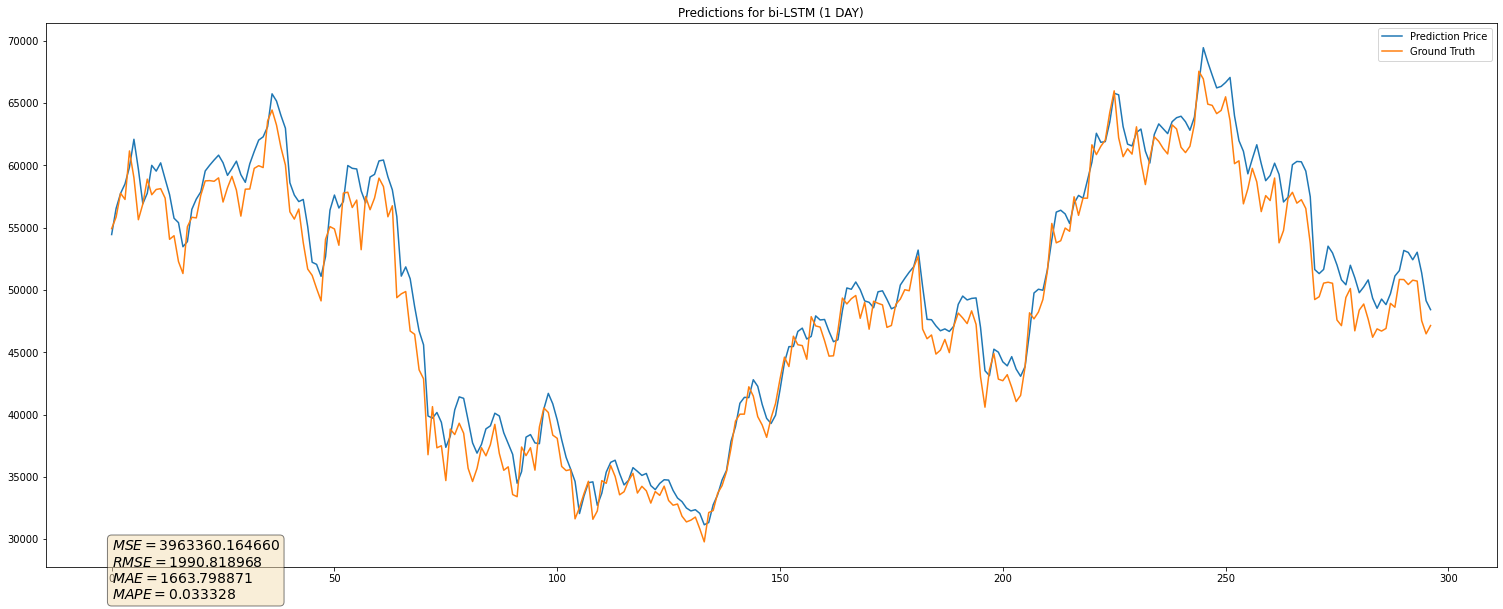

In [281]:
# prediction = np.mean(np.array(pred_GRU), axis=0)
pred_prices = scaler_label.inverse_transform(pred_GRU)
true_prices = scaler_label.inverse_transform(y_test.reshape(-1,1))

mse = mean_squared_error(pred_prices, true_prices)
rmse = mean_squared_error(pred_prices, true_prices, squared=False)
mae = mean_absolute_error(pred_prices, true_prices)
mape = mean_absolute_percentage_error(pred_prices, true_prices)

metrics = '\n'.join((
    '$MSE=%f$' % (mse),
    '$RMSE=%f$' % (rmse),
    '$MAE=%f$' % (mae),
    '$MAPE=%f$' % (mape)
))

plt.figure(figsize=(26, 10))
plt.plot(pred_prices, label='Prediction Price')
plt.plot(true_prices, label='Ground Truth')
plt.legend()

'''CHANGE TITLE'''
plt.title('Predictions for bi-LSTM (1 DAY)')

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0, 30000, metrics, fontsize=14,
        verticalalignment='top', bbox=props)

# plt.savefig('no_senti.png', dpi=500)
plt.show()